# Devoir 9
**Raphaël Blaude - 55112200**

In [1]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from pymatgen.io.cif import CifParser
from pymatgen.ext.matproj import MPRester
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [2]:
mp_key = "NKfarLsNHvBTHM4FxxhUlnMjaXDHo7fy"
mp_id = "mp-22473"

In [3]:
with MPRester(mp_key) as m:
    primitive_structure = m.get_structure_by_material_id(mp_id)
    el_bs = m.get_bandstructure_by_material_id(mp_id)
    el_dos = m.get_dos_by_material_id(mp_id)
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)
    conventionnelle_structure = SpacegroupAnalyzer(primitive_structure).get_conventional_standard_structure()
    symmops = SpacegroupAnalyzer(conventionnelle_structure).get_space_group_operations()

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

# Mon travail

## Calcul de $\Theta_D$ et $\Theta_E$

Le modèle d'Einstein fait l'hypothèse que toutes les fréquences $\omega_\sigma(\textbf{q})$ sont égales à une fréquence naturelle de vibration $\omega_E$. La chaleur spécifique s'écrit alors $$C_v = 3\ N_a\ R\ (\frac{\Theta_E}{T})^2\ \frac{e^{\Theta_E/T}}{(e^{\Theta_E/T} - 1)^2}$$ où $k_B\ \Theta_E = \hbar\ \omega_E$


Le modèle de Debye fait l'hypothèse que toutes les fréquences ont la même dispersion linéaire $\omega_\sigma(\textbf{q}) = vq$. En effectuant le changement de variable $x = (\hbar\ v\ q)\ / \ (k_B\ T)$, la chaleur spécifique s'écrit alors:
$$C_v = 9\ N_{at}\ R\ (\frac{T}{\Theta_D})^3 \int_{0}^{\Theta_d/T} \frac{x^4\ e^x}{(e^x - 1)^2} dx$$


Nous allons dans cette section calculer les températures de Debye et d'Einstein en minimisant l'erreur au sens des moindres carrés sur l'ensemble de la courbe de chaleur spécifique de 5 à 800 K en nous servant des valeurs réelles de $C_v$ que nous connaissons.

In [4]:
# Estimation grossière des températures d'Einstein et de Debye

R = 8.314
N_at = len(primitive_structure)
T = np.arange(5,800,1) # [K]
Cv_real = np.array([ph_dos.cv(T[i]) for i in range(len(T))])/(3*N_at*R)

def Cv_Debye(theta_D, T):
    def integrand(x):
        return (x**4 * np.exp(x)) / (np.exp(x) - 1)**2
    def single_Cv(temp):
        upper = theta_D / temp
        integral, _ = quad(integrand, 0, upper)
        return 3 * (temp / theta_D)**3 * integral
    vectorized_Cv = np.vectorize(single_Cv)
    return vectorized_Cv(T)

def Cv_Einstein(theta_E,T):
    return (theta_E/T)**2 * np.exp(theta_E/T) / (np.exp(theta_E/T) - 1)**2

T_grossier = np.arange(10,801,10)
error_E = np.inf
error_D = np.inf
T_D = -1
T_E = -1

for i in T_grossier:
    new_error_E = np.sum((Cv_Einstein(i,T)-Cv_real)**2)
    new_error_D = np.sum((Cv_Debye(i,T)-Cv_real)**2)
    if new_error_E < error_E:
        error_E = new_error_E
        T_E = i
    if new_error_D < error_D:
        error_D = new_error_D
        T_D = i

print("Température de Debye grossièrement estimée: ", T_D, " [K]")
print("Température d'Einstein grossièrement estimée: ", T_E, " [K]")

Température de Debye grossièrement estimée:  230  [K]
Température d'Einstein grossièrement estimée:  170  [K]


In [5]:
# Affinement de l'estimation de la température d'Einstein et de Debye

range_T_E = np.arange(T_E-10,T_E+10,0.1)
range_T_D = np.arange(T_D-10,T_D+10,0.1)

for i in range_T_E:
    new_error_E = np.sum((Cv_Einstein(i,T)-Cv_real)**2)
    if new_error_E < error_E:
        error_E = new_error_E
        T_E = i        
for i in range_T_D:
    new_error_D = np.sum((Cv_Debye(i,T)-Cv_real)**2)
    if new_error_D < error_D:
        error_D = new_error_D
        T_D = i

print("Température de Debye finement estimée: ", round(T_D,1), " [K]")
print("Température d'Einstein finement estimée: ", round(T_E,1), " [K]")

Température de Debye finement estimée:  233.59999999999923  [K]
Température d'Einstein finement estimée:  172.79999999999927  [K]


## Représentation des courbes de chaleur spécifique

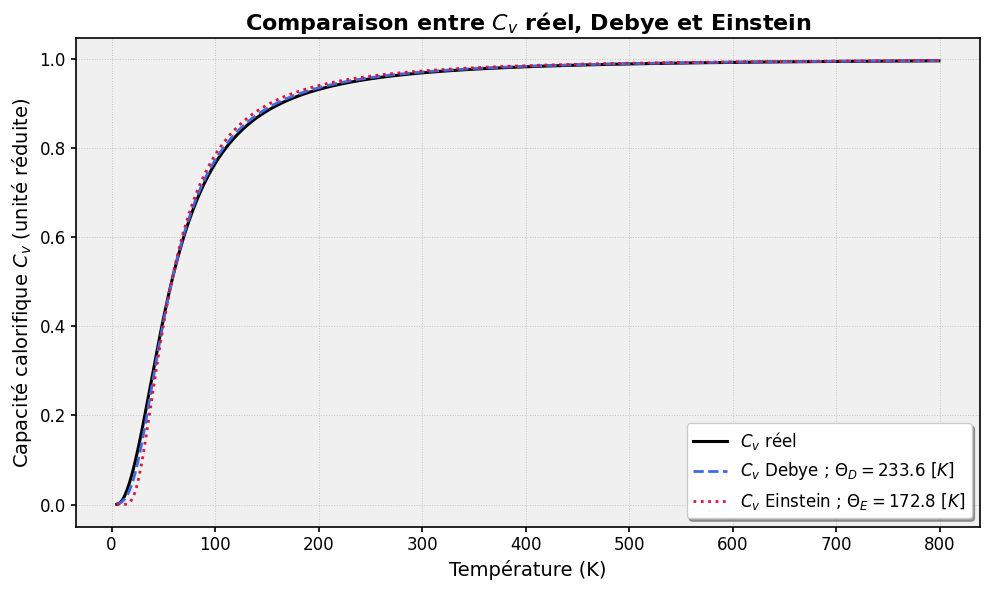

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(T, Cv_real, label=r"$C_v$ réel", color="black", linewidth=2.2, linestyle='-')
plt.plot(T, Cv_Debye(T_D, T), label=r"$C_v$ Debye ; $\Theta_D = 233.6\ [K]$", color="royalblue", linewidth=2, linestyle='--')
plt.plot(T, Cv_Einstein(T_E, T), label=r"$C_v$ Einstein ; $\Theta_E = 172.8\ [K]$", color="crimson", linewidth=2, linestyle=':')
plt.legend(loc='lower right', fontsize=12, frameon=True, shadow=True)
plt.xlabel("Température (K)", fontsize=14)
plt.ylabel(r"Capacité calorifique $C_v$ (unité réduite)", fontsize=14)
plt.title(r"Comparaison entre $C_v$ réel, Debye et Einstein", fontsize=16, weight='bold')
plt.grid(True, linestyle=':', linewidth=0.7, alpha=0.7)
plt.gca().set_facecolor('#f0f0f0')
plt.gcf().patch.set_facecolor('white')
plt.tick_params(axis='both', which='major', labelsize=12, width=1.2)
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.2)
plt.tight_layout()
plt.show()

J'ai été chercher au-delà des bornes de température actuelles entre 5 et 800 K pour trouver les températures de Debye et d'Einstein mais pour des raisons de rapidité d'exécution du code et de lisibilité du graphe, plus précisément pour mieux distinguer les courbes entre elles, j'ai restreint la plage de recherche.

Remarquons que dès 600 K les courbes des trois modèles $C_v$ tendent déjà vers 1. C'est la loi de Dulong et Petit normalisée, qu'à haute température, la chaleur spécifique tend vers une constante égale à 1 (si non normalisé vers $3\ N_{at}\ R$). Remarquons que $C_v$ tend effectivement vers 1 quand $T >> \Theta_D$ et $T >> \Theta_E$.

Pour $\Theta_D << T$, $C_v$ suit une loi en $T^3$ pour le modèle de Debye.

Pour $\Theta_D << T$, $C_v$ suit une loi en $e^{-\Theta_E/T}$ pour le modèle d'Einstein.

Le modèle de Debye est le plus proche de la réalité entre les deux modèles. Il est plus correct à basse température, contrairement au modèle d'Einstein qui s'en écarte un peu plus.

## Densités d'états de phonons correspondantes

La densité d'état de phonons représente les modes de vibration accessibles.

Dans le modèle d'Einstein, la densité d'état $g_E(\omega)$ est un delta de Dirac situe en $\omega_E = \frac{k_B\ \Theta_E}{\hbar}$ la fréquence d'Einstein.
$$g_E(\omega) = 3\ N_{at}\ \delta(\omega - \omega_E)$$
où $N_{at}$ est le nombre d'atomes dans la maille primitive.


Dans le modèle de Debye, la densité d'état $g_D(\omega)$ est une fonction parabolique de la fréquence:
$$g_D(\omega) = \frac{3\ N_{at}\ \Omega}{2\ \pi^2} \int_{0}^{q_D} \delta(\omega - vq)\ q^2\ dq$$
où $\Omega$ est le volume de la maille primitive. Ce qui est égal à $\frac{3\ N_{at}\ \Omega\ \omega^2}{2\ \pi^2\ v^3}\ \ \ \forall\ \omega < \omega_D = vq_D$, et 0 $\forall\ \omega > \omega_D$. Il faut par ailleurs utiliser la relation $k_b\ \Theta_D = \hbar\ \omega_D$


On peut voir sur le graphe ci-dessous que l'aire sous les courbes de densité d'état du modèle de Debye semble effectivement assez proche de l'aire sous la courbe réelle. Par définition du delta de Dirac, la valeur sous la courbe de la densité d'état d'Einstein est égale à $3\ N_{at}$. En outre, la courbe de Debye et la courbe réelle coïncident quand $\omega$ tend vers 0.

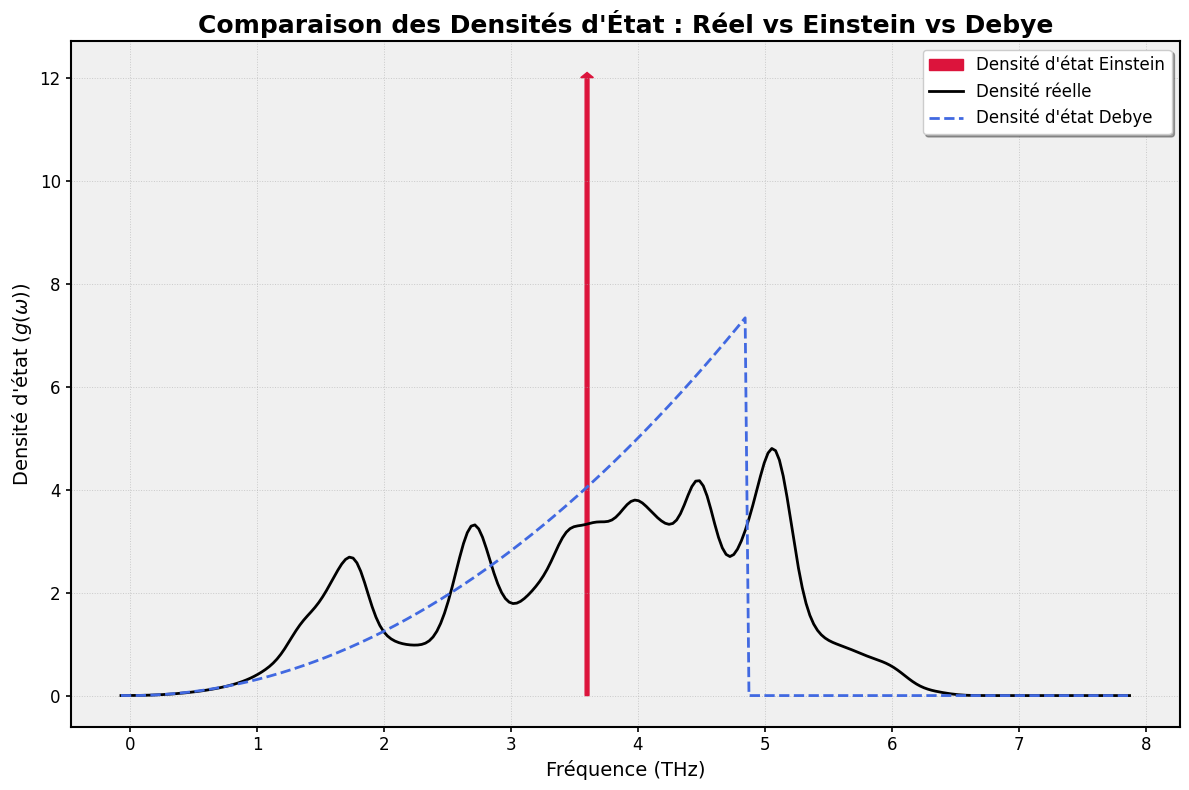

In [61]:
hbarre = 6.626e-34 / 2 / np.pi
kb = 1.38e-23
freq = ph_dos.frequencies
dens = ph_dos.densities
N_at = len(primitive_structure)
Omega = 96.19e-30

# Calcul de la densité d'Einstein
omega_E = kb*T_E/hbarre * 1e-12 # [THz]
f_E = omega_E / 2 / np.pi # 

# Calcul de la densité de Debye
omega_D = kb*T_D/hbarre * 1e-12 # [THz]
omega_d = freq.copy() * 2 * np.pi
for i in range(len(omega_d)):
    if omega_d[i] < omega_D:
        qd = (6*np.pi**2/Omega)**(1/3)
        v  = omega_D/qd
        omega_d[i] = 3 * N_at * Omega / 2 / np.pi**2 / v**3 * (omega_d[i]*2*np.pi)**2 
    else:
        omega_d[i] = 0

plt.figure(figsize=(12, 8))
plt.arrow(f_E, 0, 0, 3*N_at, width=0.03, head_width=0.1, head_length=0.1, fc='crimson', ec='crimson', label="Densité d'état Einstein", color='crimson')
plt.plot(freq, dens, color="black", linewidth=2, label="Densité réelle", linestyle='-')
plt.plot(freq, omega_d / 2 / np.pi, color='royalblue', linewidth=2, label="Densité d'état Debye", linestyle='--')
plt.title("Comparaison des Densités d'État : Réel vs Einstein vs Debye", fontsize=18, fontweight='bold')
plt.xlabel("Fréquence (THz)", fontsize=14)
plt.ylabel("Densité d'état ($g(\omega)$)", fontsize=14)
plt.legend(loc='upper right', fontsize=12, frameon=True, shadow=True)
plt.grid(True, linestyle=':', linewidth=0.7, alpha=0.6)
plt.gca().set_facecolor('#f0f0f0')
plt.gcf().patch.set_facecolor('white')
plt.tick_params(axis='both', which='major', labelsize=12, width=1.2)
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)
plt.tight_layout()
plt.show()
